In [44]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import date
from datetime import timedelta
import time
%matplotlib inline
from pathlib import Path 
import os
from matplotlib.ticker import ScalarFormatter
from matplotlib import ticker

In [45]:
#Find yesterday's date and convert it to string
today=date.today()
yesterday=today-timedelta(days=1)
ydate=yesterday.strftime("%d-%m-%Y")

#Specify Data folder
data_folder = Path("../data")

#Compute filename
data_file = ydate + ".csv"

#Compute complete filepath for the day
file_path = data_folder / data_file

#Read file to data frame
df=pd.read_csv(file_path)

df['Date']= pd.to_datetime(df['Date'], dayfirst=True)
df=df[df['Date']!=today] #Drop today's data
df_h=df[df['Status']=='Hospitalized']
df_r=df[df['Status']=='Recovered']
df_d=df[df['Status']=='Deceased']

C:\Users\joses\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.


In [46]:
#Daily New Cases count in India
ind_daily=pd.DataFrame(df_h.groupby('Date')['Num_Cases'].sum())
ind_daily.rename(columns={'Num_Cases':'Daily New Cases'}, inplace=True)
#ind_daily.tail(10)

In [47]:
#Cumulative Cases in India
ind_cum=ind_daily.cumsum()
ind_cum.rename(columns={'Daily New Cases':'Cumulative Cases'},inplace=True)

In [48]:
#Specify Export folder 
export_folder =Path("../exports")
export_folder_path = export_folder / ydate

try:
    os.mkdir(export_folder_path)
    print('New Directory Created for today')
except:
    print("Directory already exists")

#File Name for States Daily and file path
fnsd = "State Daily.csv"
fpsd = export_folder_path / fnsd

#File Name for States Cumulative and filepath 
fnsc = "State Cumulative.csv"
fpsc = export_folder_path / fnsc

Directory already exists


In [49]:
#Create a time series for States by New Cases
states=pd.DataFrame(df_h.groupby(['Date','State'])['Num_Cases'].sum())
states.rename(columns={'Num_Cases':'Daily New Cases'}, inplace=True)
state_daily=states.pivot_table(index='Date', columns='State', fill_value=0)
state_daily.to_csv(fpsd)

In [50]:
#Create a time series for States by Cumulative Cases 
state_cum=state_daily.cumsum()
state_cum.rename(columns={'Daily New Cases':'Cumulative Cases'}, inplace=True)
state_cum.tail()
state_cum.to_csv(fpsc)

In [51]:
#Arrange states in descending order of latest cumulative Cases
trans=state_cum.transpose()
sort_state=pd.DataFrame(trans[yesterday].sort_values(ascending=False))
mylist=sort_state.index.tolist() #Export to a list (Array of Cumulative Cases and State names)

In [52]:
state_list=[row[1] for row in mylist]#Creates a new list from the array above and extracts ony the state names
#Split the States into three different categories according to their rank
top10=state_list[0:10] #Top 10 States
second10=state_list[10:20] #10-20 States
last=state_list[20:] #Last set of states

In [53]:
#Select Top 10 States by Cumulative Cases
top10cum=pd.DataFrame()
for i in range(10):
    top10cum[top10[i]]=state_cum['Cumulative Cases', top10[i]]
    
#top10cum.tail()

In [54]:
#Select the second 10 states by Cumulative Cases
second10cum=pd.DataFrame()
for i in range(10):
    second10cum[second10[i]]=state_cum['Cumulative Cases', second10[i]]
    
#second10cum.tail()

In [55]:
#Select Top 10 States by Daily New Cases
top10new=pd.DataFrame()
for i in range(10):
    top10new[top10[i]]=state_daily['Daily New Cases', top10[i]]
    
#top10new.tail()

In [56]:
#Select the second 10 states by Daily New Cases
second10new=pd.DataFrame()
for i in range(10):
    second10new[second10[i]]=state_daily['Daily New Cases', second10[i]]
    
#second10new.tail()

In [57]:
#Select the last set of states by Daily New Cases
lastnew=pd.DataFrame()
for i in range(len(last)):
    lastnew[last[i]]=state_daily['Daily New Cases', last[i]]

#lastnew.tail()

In [58]:
#Select the last set of states by Cumulative Cases
lastcum=pd.DataFrame()
for i in range(len(last)):
    lastcum[last[i]]=state_cum['Cumulative Cases', last[i]]

#lastcum.tail()

In [59]:
#Calculate the 7 day Rolling Average for Daily New Cases in india
ind_daily_7dra=pd.DataFrame()
ind_daily_7dra[ind_daily.columns[0]]=ind_daily.iloc[:,0].rolling(window=7).mean()

In [60]:
#Calculate 7-Day Rolling Average for Top 10 States
top10new7dra=pd.DataFrame()
for i in range(10):
    name=top10new.columns[i]
    top10new7dra[name]= top10new.iloc[:,i].rolling(window=7).mean()

#top10new7dra.tail()

In [61]:
top10new7dra2=pd.DataFrame()
for i in range(10):
    name=top10new7dra.columns[i]
    top10new7dra2[name]=top10new7dra.iloc[:,i]
top10new7dra2.reset_index(drop=True,inplace=True)
#top10new7dra2.tail()

In [62]:
#Extract Data where average cases >10 (set range 8-15 to include all states)
top10new7dra_dat=pd.DataFrame()
for j in range(10):
    for i in range(60):
        if top10new7dra2.iloc[i,j] < 15.2:
            if top10new7dra2.iloc[i,j] > 8.0:
                name=top10new7dra2.columns[j]
                top10new7dra_dat[name]=top10new7dra2.iloc[i:,j]
                break
    continue
    
#Remove the date column and reset index
top10new7dra_dat.reset_index(drop=True,inplace=True)

#Remove NaN at top and align rows for different states
top10new7dra_dat2=pd.DataFrame()
for i in range(10):
    top10new7dra_dat[top10new7dra_dat.columns[i]].dropna(inplace=True)
    top10new7dra_dat[top10new7dra_dat.columns[i]].reset_index(drop=True,inplace=True)
    top10new7dra_dat2[top10new7dra_dat.columns[i]]=top10new7dra_dat[top10new7dra_dat.columns[i]]
    
#top10new7dra_dat2.head()

In [63]:
#Graph Starting date is 23rd April; Calculate number of days as integer
x=(today-date(2020,3,23)).days

In [64]:
chart_folder= Path("../charts")
export_path=chart_folder/ydate
export_path
try:
    os.mkdir(export_path)
    print('New Directory Created for today')
except:
    print("Directory already exists")


Directory already exists


In [65]:
yticks=[1, 5,10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

#    Plots Start From Here

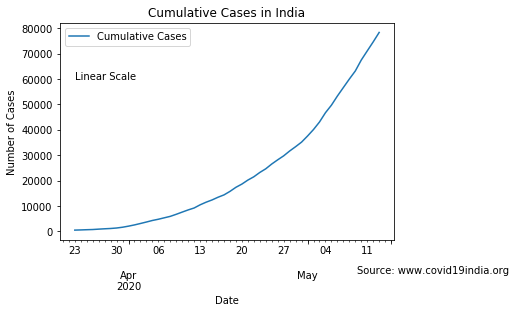

In [66]:
#Plot Cumulative Cases in India as a linear plot
fig1_path=export_path / "Figure 1.jpg"
ind_cum.tail(x).plot(kind='line')
plt.title('Cumulative Cases in India')
plt.text('23-03-2020',60000,"Linear Scale")
plt.figtext(0.99, 0.01, 'Source: www.covid19india.org', horizontalalignment='center')
plt.ylabel('Number of Cases')
plt.savefig(fig1_path, dpi=300, bbox_inches='tight')
plt.show()

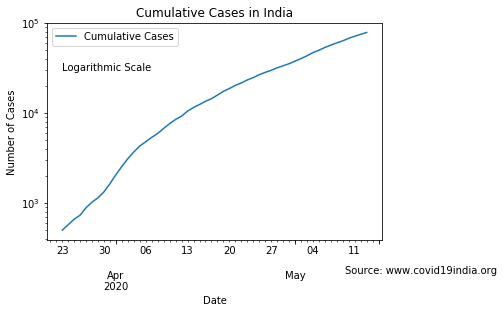

In [67]:
#Plot Cumulative Cases in India in Log scale
fig2_path=export_path / "Figure 2.jpg"
ind_cum.tail(x).plot(kind='line').set_yscale('log')
plt.title('Cumulative Cases in India')
plt.text('23-03-2020',30000,"Logarithmic Scale")
plt.figtext(0.99, 0.01, 'Source: www.covid19india.org', horizontalalignment='center')
plt.ylabel('Number of Cases')
plt.savefig(fig2_path, dpi=300, bbox_inches='tight')
plt.show()

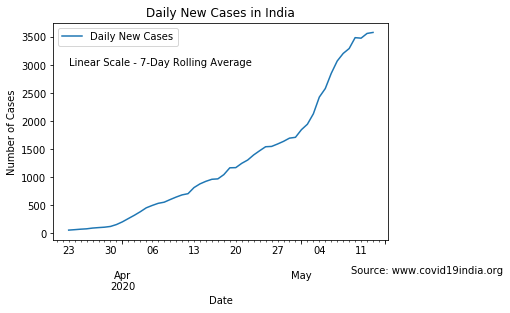

In [68]:
#Plot Daily New Cases in India (7DRA) as linear plot
fig3_path=export_path / "Figure 3.jpg"
ind_daily_7dra.tail(x).plot(kind='line')
plt.title('Daily New Cases in India')
plt.text('23-03-2020',3000,"Linear Scale - 7-Day Rolling Average")
plt.figtext(0.99, 0.01, 'Source: www.covid19india.org', horizontalalignment='center')
plt.ylabel('Number of Cases')
plt.savefig(fig3_path, dpi=300, bbox_inches='tight')
plt.show()

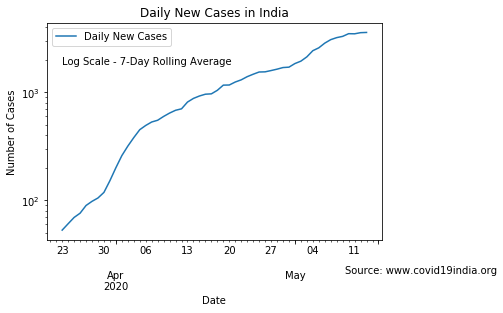

In [69]:
#Plot Daily New Cases 7DRA as log plot
fig4_path=export_path / "Figure 4.jpg"
ind_daily_7dra.tail(x).plot(kind='line').set_yscale('log')
plt.title('Daily New Cases in India')
plt.figtext(0.99, 0.01, 'Source: www.covid19india.org', horizontalalignment='center')
plt.text('23-03-2020',1800,"Log Scale - 7-Day Rolling Average")
plt.ylabel('Number of Cases')
plt.savefig(fig4_path,dpi=300, bbox_inches='tight')
plt.show()

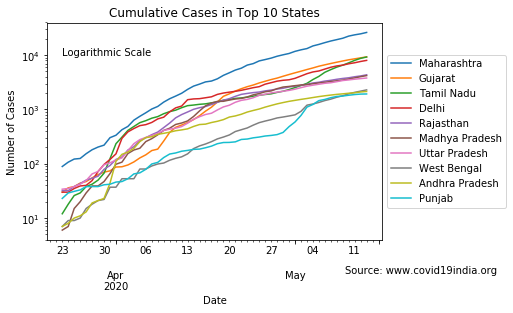

In [70]:
#Plot Top 10 States Cumulative Cases in Log Scale
fig5_path=export_path / "Figure 5.jpg"
top10cum.tail(x).plot(kind='line').set_yscale('log')
plt.title('Cumulative Cases in Top 10 States')
plt.text('23-03-2020',10000,"Logarithmic Scale")
plt.figtext(0.99, 0.01, 'Source: www.covid19india.org', horizontalalignment='center')
plt.ylabel('Number of Cases')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig(fig5_path,dpi=300, bbox_inches='tight')
plt.show()

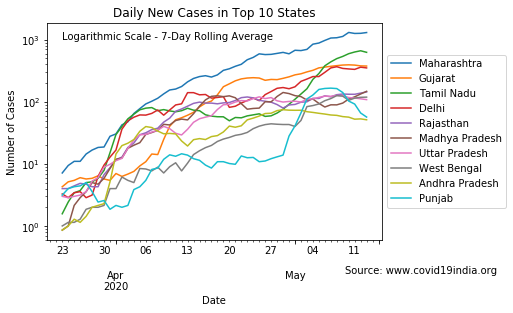

In [71]:
#Plot the 7DRA graph for Daily New Cases - States in Log Scale
fig6_path=export_path / "Figure 6.jpg"
top10new7dra.tail(x).plot(kind='line').set_yscale('log')
plt.title('Daily New Cases in Top 10 States')
plt.text('23-03-2020',1000,"Logarithmic Scale - 7-Day Rolling Average")
plt.figtext(0.99, 0.01, 'Source: www.covid19india.org', horizontalalignment='center')
plt.ylabel('Number of Cases')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig(fig6_path,dpi=300, bbox_inches='tight')
plt.show()

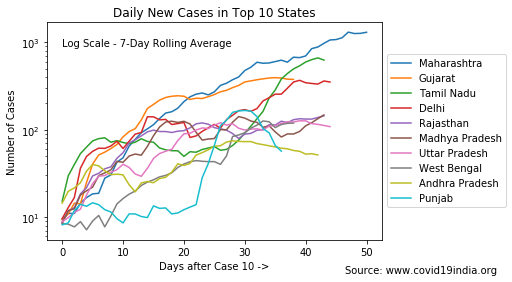

In [72]:
#Plot the 7DRA graph for Daily New Cases Day after case 10- States in Log Scale
fig7_path=export_path / "Figure 7.jpg"
top10new7dra_dat2.plot(kind='line').set_yscale('log')
#plt.figure(figsize=(4,4))
plt.title('Daily New Cases in Top 10 States')
plt.text(0,900,"Log Scale - 7-Day Rolling Average")
plt.figtext(0.99, 0.01, 'Source: www.covid19india.org', horizontalalignment='center')
plt.xlabel('Days after Case 10 ->')
plt.ylabel('Number of Cases')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig(fig7_path,dpi=300, bbox_inches='tight')
plt.show()


#  Top 11-20 States

In [73]:
#Calculate 7-Day Rolling Average for Top 11-20 States
second10new7dra=pd.DataFrame()
for i in range(10):
    name=second10new.columns[i]
    second10new7dra[name]= second10new.iloc[:,i].rolling(window=7).mean()

second10new7dra2=pd.DataFrame()
for i in range(10):
    name=second10new7dra.columns[i]
    second10new7dra2[name]=second10new7dra.iloc[:,i]
second10new7dra2.reset_index(drop=True,inplace=True)
    
#Extract Data where average cases >3 (set range 8-11 to include all states)
second10new7dra_dat=pd.DataFrame()
for j in range(10):
    for i in range(70):
        if second10new7dra2.iloc[i,j] < 11.0:
            if second10new7dra2.iloc[i,j] > 8.0:
                name=second10new7dra2.columns[j]
                second10new7dra_dat[name]=second10new7dra2.iloc[i:,j]
                break
    continue
    
#Remove the date column and reset index
second10new7dra_dat.reset_index(drop=True,inplace=True)

#Remove NaN at top and align rows for different states
second10new7dra_dat2=pd.DataFrame()
for i in range(10):
    second10new7dra_dat[second10new7dra_dat.columns[i]].dropna(inplace=True)
    second10new7dra_dat[second10new7dra_dat.columns[i]].reset_index(drop=True,inplace=True)
    second10new7dra_dat2[second10new7dra_dat.columns[i]]=second10new7dra_dat[second10new7dra_dat.columns[i]]
    
#second10new7dra_dat2.head()

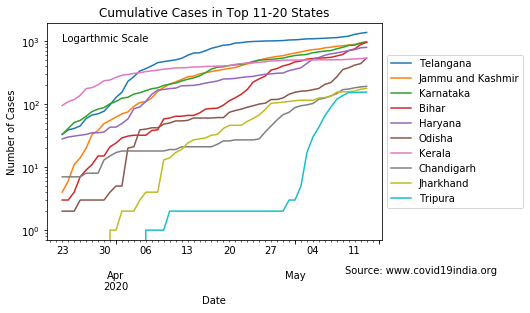

In [74]:
#Plot Top 10 States Cumulative Cases in Log Scale
fig8_path=export_path / "Figure 8.jpg"
second10cum.tail(x).plot(kind='line').set_yscale('log')
plt.title('Cumulative Cases in Top 11-20 States')
plt.text('23-03-2020',1000,"Logarthmic Scale")
plt.figtext(0.99, 0.01, 'Source: www.covid19india.org', horizontalalignment='center')
plt.ylabel('Number of Cases')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig(fig8_path,dpi=300, bbox_inches='tight')
plt.show()

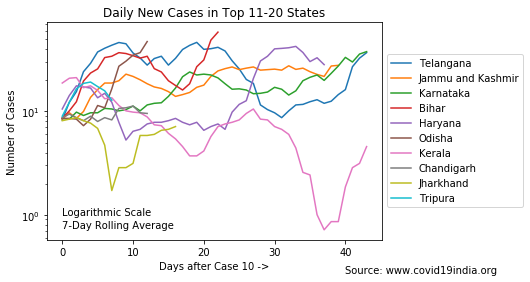

In [75]:
#Plot Top 10 States Cumulative Cases in Log Scale
fig9_path=export_path / "Figure 9.jpg"
second10new7dra_dat2.plot(kind='line').set_yscale('log')
plt.title('Daily New Cases in Top 11-20 States')
plt.text(0,1,"Logarithmic Scale")
plt.text(0,0.75,"7-Day Rolling Average")
plt.figtext(0.99, 0.01, 'Source: www.covid19india.org', horizontalalignment='center')
plt.ylabel('Number of Cases')
plt.xlabel('Days after Case 10 ->')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.savefig(fig9_path,dpi=300, bbox_inches='tight')
plt.show()

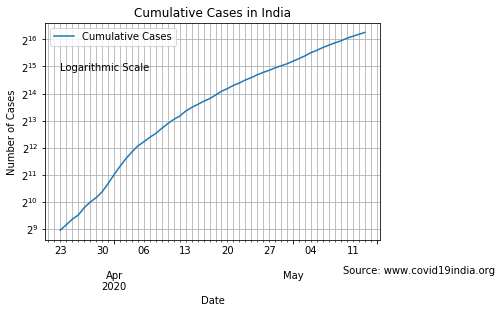

In [76]:
#Plot Cumulative Cases in India in Log scale
#fig2_path=export_path / "Figure 2.jpg"
ind_cum.tail(x).plot(kind='line').set_yscale('log', basey=2)
plt.grid(which='minor', axis='x')
plt.grid(which='major', axis='y')
plt.title('Cumulative Cases in India')
plt.text('23-03-2020',30000,"Logarithmic Scale")
plt.figtext(0.99, 0.01, 'Source: www.covid19india.org', horizontalalignment='center')
plt.ylabel('Number of Cases')
#plt.savefig(fig2_path, dpi=300, bbox_inches='tight')
plt.show()

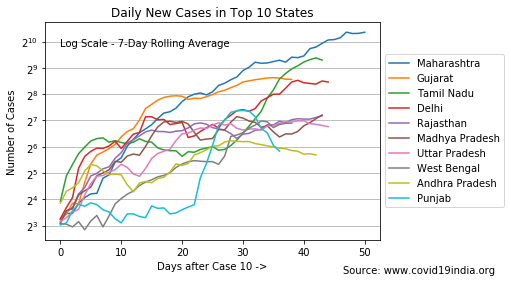

In [77]:
#Plot the 7DRA graph for Daily New Cases Day after case 10- States in Log Scale
#fig7_path=export_path / "Figure 7.jpg"
top10new7dra_dat2.plot(kind='line').set_yscale('log', basey=2)
plt.grid(which='minor', axis='x')
plt.grid(which='major', axis='y')
#plt.figure(figsize=(4,4))
plt.title('Daily New Cases in Top 10 States')
plt.text(0,900,"Log Scale - 7-Day Rolling Average")
plt.figtext(0.99, 0.01, 'Source: www.covid19india.org', horizontalalignment='center')
plt.xlabel('Days after Case 10 ->')
plt.ylabel('Number of Cases')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
#plt.savefig(fig7_path,dpi=300, bbox_inches='tight')
plt.show()